In [1]:
import adaptive_latents as al
from adaptive_latents import NumpyTimedDataSource, Bubblewrap, AnimationManager, default_rwd_parameters, SymmetricNoisyRegressor, BWRun
from adaptive_latents.input_sources.functional import prosvd_data, clip, zscore
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from proSVD import proSVD

In [2]:
file = '/home/jgould/Documents/Bubblewrap/generated/datasets/sbp/OnlineTrainingData.mat'
mat = loadmat(file, squeeze_me=True, simplify_cells=True)
data = mat['OnlineTrainingData']
n_channels = data[0]['SpikingBandPower'].shape[1]

In [3]:
for i in range(len(data)-1):
    assert data[i+1]['ExperimentTime'][0] - data[i]['ExperimentTime'][-1] == 3

In [4]:
A = []
t = []
beh = []
for i, trial in enumerate(data):
    A_spacer = np.nan * np.zeros((3,n_channels))
    t_spacer = np.arange(1,4) + trial['ExperimentTime'][-1]
    beh_spacer = t_spacer * np.nan
    if i == len(data)-1:
        A_spacer = np.zeros((0,n_channels))
        t_spacer = []
        beh_spacer = []
    sub_A_spaced = np.vstack([trial['SpikingBandPower'], A_spacer])
    sub_t_spaced = np.hstack([trial['ExperimentTime'], t_spacer])
    sub_beh_spaced = np.hstack([trial['FingerAngle'], beh_spacer])
    A.append(sub_A_spaced)
    t.append(sub_t_spaced)
    beh.append(sub_beh_spaced)
A = np.vstack(A)
t = np.hstack(t) / 1000 # converts to seconds
beh = np.hstack(beh)

s = t > 1.260
A, beh, t = A[s], beh[s], t[s]


bin_size = 150
aug = np.column_stack([t,beh, A])
binned_aug = aug[aug.shape[0] % bin_size:,:].reshape(( -1, bin_size, aug.shape[1]))
t = binned_aug[:,:,0].max(axis=1)
beh = np.nanmean(binned_aug[:,:,1], axis=1)
A = np.nanmean(binned_aug[:,:,2:], axis=1)

# kernel = np.exp(np.linspace(-3,0, 10))
# kernel /= kernel.sum()
# kernel = np.flip(kernel)

# A, beh, t = clip(zscore(A), beh, t)
edge = 100
pre_pro_A = (A[edge:] - A[:edge].mean(axis=0))

In [5]:
# pre_pro_A, raw_behavior, bin_centers, beh_t = al.input_sources.datasets.construct_indy_data(
#     individual_identifier=al.input_sources.datasets.individual_identifiers["indy"][0], 
#     bin_width=.03
# )
# resampled_behavior = al.input_sources.functional.resample_behavior(raw_behavior, bin_centers, beh_t)
# beh = resampled_behavior
# t = bin_centers

Text(0.5, 0, 'number of components')

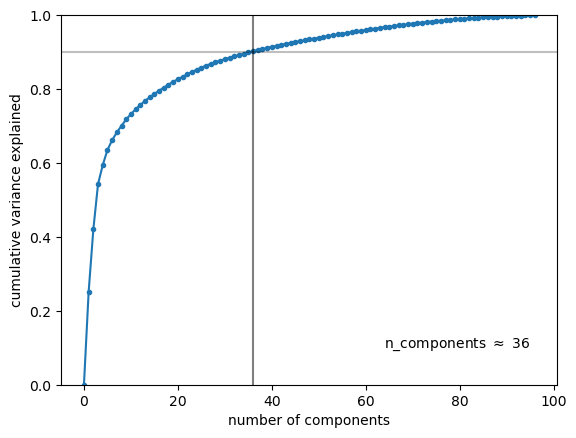

In [6]:
pca = PCA()
pca.fit(pre_pro_A)

fig, ax = plt.subplots()
var_explained = np.cumsum([0] + list(pca.explained_variance_ratio_))
ax.plot(var_explained, '.-')
ax.set_ylim([0,1])
cutoff = np.nonzero(var_explained > .9)[0][0]
ax.axvline(cutoff, color='k', alpha=.5)
ax.axhline(.9, color='k', alpha=.25)
ax.text(.65,.1, f'n_components $\\approx$ {cutoff}', transform=ax.transAxes)
ax.set_ylabel("cumulative variance explained")
ax.set_xlabel("number of components")

In [7]:
def prosvd_data_and_Qs(input_arr, output_d, init_size):
    pro = proSVD(k=output_d)
    pro.initialize(input_arr[:init_size].T)

    output = []
    old_Qs = []
    for i in range(init_size, len(input_arr)):
        obs = input_arr[i:i + 1, :]
        if np.any(np.isnan(obs)):
            output.append(np.zeros(output_d) * np.nan)
            continue
        old_Qs.append(np.array(pro.Q))
        pro.preupdate()
        pro.updateSVD(obs.T)
        pro.postupdate()

        obs = obs @ pro.Q

        output.append(obs)
    return np.array(output).reshape((-1, output_d)), np.array(old_Qs)

A, Qs = prosvd_data_and_Qs(pre_pro_A, 7, 50)
A, t, beh = clip(A, t, beh)

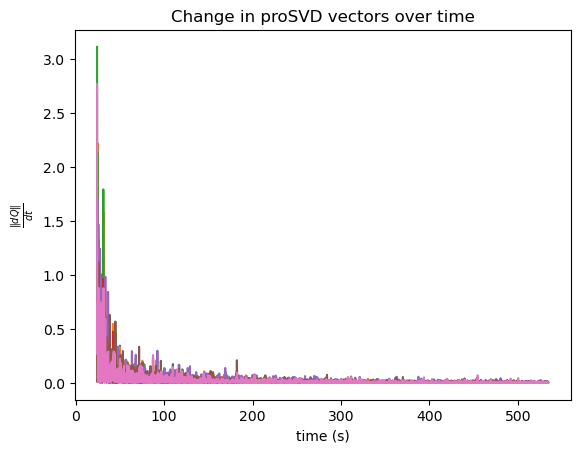

In [8]:
fig, ax = plt.subplots()
dQ = np.linalg.norm(np.diff(Qs, axis=0), axis=1)
dt = np.diff(t)
ax.plot(t[:-1], dQ/dt[:,None]);
ax.set_ylabel("$\\frac{ \\Vert dQ \\Vert}{dt}$");
ax.set_title("Change in proSVD vectors over time");
ax.set_xlabel("time (s)");

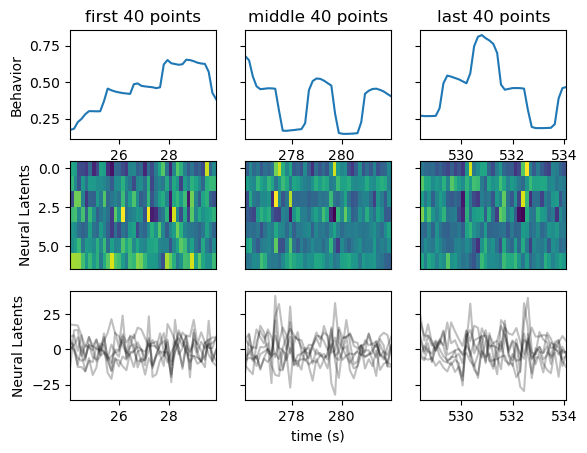

In [9]:
%matplotlib inline
fig, axs = plt.subplots(nrows=3, ncols=3, sharey='row')

slice_half_width = 20
time_slices = [slice(0,slice_half_width*2), 
               slice(len(t)//2-slice_half_width, len(t)//2+slice_half_width) , 
               slice(-slice_half_width*2, -1)]
for i in range(3):
    s = time_slices[i]
    axs[0,i].plot(t[s],beh[s])
    axs[0,i].set_xlim([min(t[s]), max(t[s])])
    axs[1,i].imshow(A[s,:].T, aspect='auto', interpolation='none')
    axs[1,i].set_xticks([])
    axs[2,i].plot(t[s],A[s,:], color='k', alpha=.25)
    axs[2,i].set_xlim([min(t[s]), max(t[s])])

axs[0,0].set_title(f"first {slice_half_width*2} points")
axs[0,1].set_title(f"middle {slice_half_width*2} points")
axs[0,2].set_title(f"last {slice_half_width*2} points")

axs[0,0].set_ylabel("Behavior")
axs[1,0].set_ylabel("Neural Latents")
axs[2,0].set_ylabel("Neural Latents")
axs[2,1].set_xlabel("time (s)");

In [10]:
from adaptive_latents import default_rwd_parameters

In [11]:
in_ds = NumpyTimedDataSource(A, t, time_offsets=(1,))
out_ds = NumpyTimedDataSource(beh, t, time_offsets=(1,))

# define the adaptive_latents object
bw = Bubblewrap(dim=in_ds.output_shape,  **dict(default_rwd_parameters, M=300, num=100, num_grad_q=3))

# define the (optional) method to regress the HMM state from `bw.alpha`
# reg = SymmetricNoisyRegressor(input_d=bw.N, output_d=1)
reg = SymmetricNoisyRegressor(input_d=bw.N, output_d=out_ds.output_shape)

class CustomAnimation(AnimationManager):
    n_rows = 1
    n_cols = 1
    figsize = (15,10)
    extension = "mp4"
    fps=10

    def custom_draw_frame(self, step, bw: Bubblewrap, br: BWRun):
        historical_observations = br.obs_ds.get_history()

        # al.plotting_functions.show_data_2d(self.ax[0,0], historical_observations, bw, n=7)
        al.plotting_functions.show_bubbles_2d(self.ax[0,0], historical_observations, bw, n_sds=3)
        self.ax[0,0].set_title(f"Step {step}")
        
    def frame_draw_condition(self, step_number, bw):
        return (step_number % 10 == 0) and (step_number > 100)
        
# am = CustomAnimation()
am = None

br = BWRun(bw=bw, obs_ds=in_ds, beh_ds=out_ds, behavior_regressor=reg, animation_manager=am, show_tqdm=True)

br.run(limit=1000)

1001it [00:17, 58.57it/s]                                                       


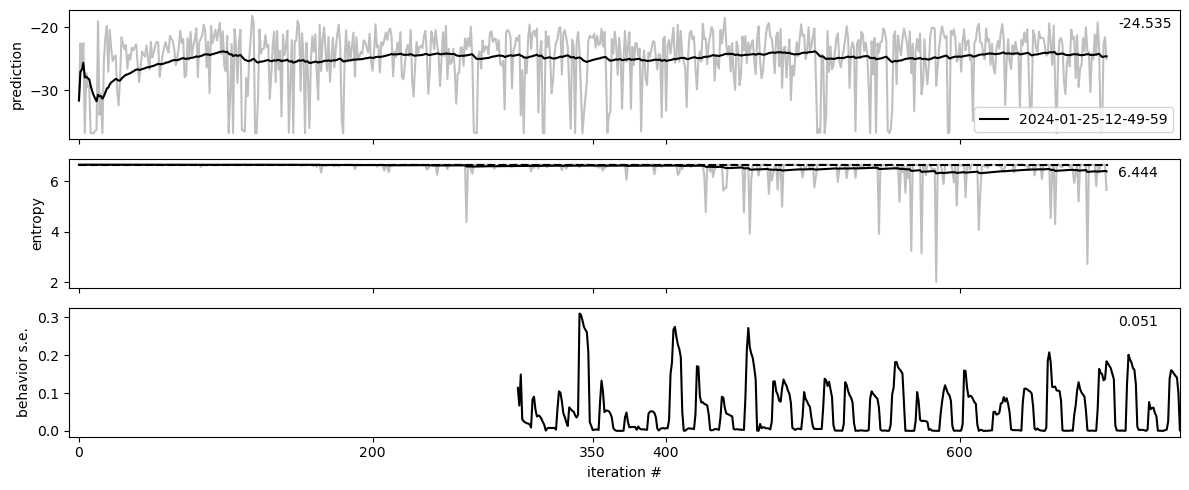

In [12]:
al.plotting_functions.compare_metrics([br], offset=1)

In [13]:
def get_polar_path(points):
    angles = []
    lengths = []
    for i in range(1,points.shape[0]-1):
        # here we define unit vectors paralell to the i and (i+1)th line segments in `points`
        current_segment = points[i] - points[i-1]
        next_segment = points[i+1] - points[i]
        lengths.append(np.linalg.norm(next_segment))
        current_segment /= np.linalg.norm(current_segment)
        next_segment /= np.linalg.norm(next_segment)
        
        # calculate the angle using arccos
        angle_magnitude = np.arccos(current_segment @ next_segment)
        angle_sign = -np.sign(np.linalg.det(np.column_stack([current_segment, next_segment])))
        angle_by_cos = angle_magnitude * angle_sign
        
        # calculate the angle using atan2
        orth_to_current_segment = np.array([[0,-1],[1,0]]) @ current_segment
        angle_by_atan2 = np.arctan2(next_segment @ orth_to_current_segment, next_segment @ current_segment)
        
        # check that both methods give the correct answer
        if not np.isclose(-angle_by_cos, angle_by_atan2):
            print(f"{-angle_by_cos} {angle_by_atan2}")
        
        
        angles.append(angle_by_cos)
    return angles, lengths
def make_angle_plot(ax, angles, lengths, bins=16, density=True):
    bins = np.linspace(-np.pi, np.pi, num=bins+1)
    
    # Bin data and record counts
    n, bins = np.histogram(angles, weights=lengths, bins=bins)
    widths = np.diff(bins)
    
    if density:
        # Area to assign each bin
        area = n / len(angles)
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n
    
    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)
    
    # Set the direction of the zero angle
    ax.set_theta_offset(np.pi/2)
    
    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

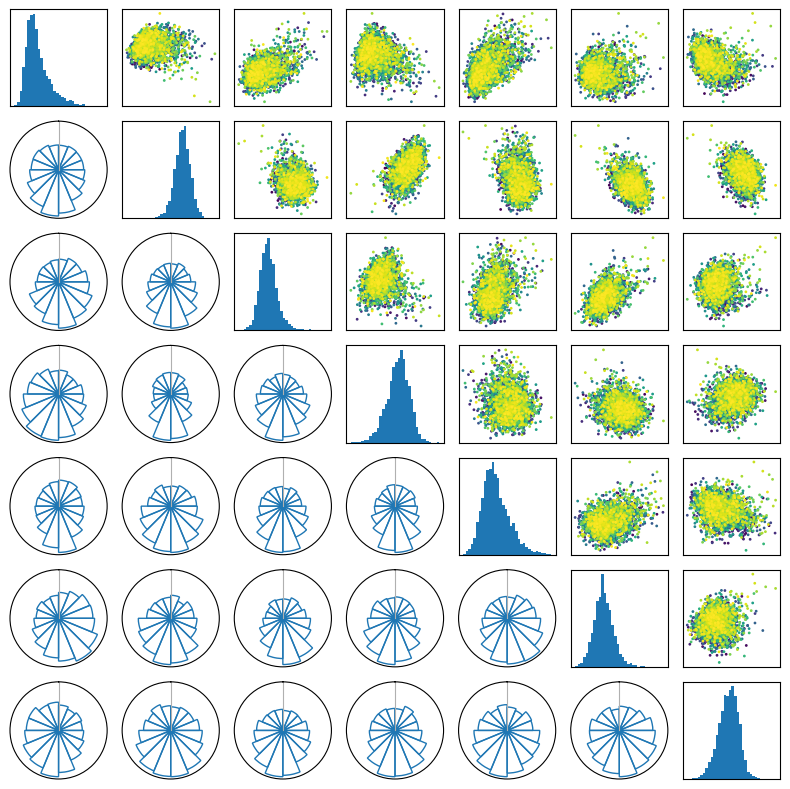

In [14]:
def inspect_high_d(A, fig=None, axs=None):
    k = A.shape[1]
    if fig is None or axs is None:
        fig, axs = plt.subplots(nrows=k, ncols=k, figsize=(8,8), tight_layout=True)
    
    for i in range(k):
        for j in range(k):
            if i < j:
                axs[i,j].scatter(A[:,i], A[:,j], c=t, s=1)
                axs[i,j].set_xticks([])
                axs[i,j].set_yticks([])
            elif i == j:
                axs[i,j].hist(A[:,i], bins=A.shape[0]//100)
                axs[i,i].set_xticks([])
                axs[i,i].set_yticks([])
            else:
                axs[i,j].remove()
                axs[i,j] = fig.add_subplot(k, k, (i*k +j)+1, projection='polar')
                angles, lengths = get_polar_path(A[:,[i,j]])
                make_angle_plot(axs[i,j], angles, lengths)
                
                axs[i,j].set_yticks([])
                axs[i,j].set_xticks([0])
                axs[i,j].set_xticklabels([""])
inspect_high_d(A)

### Some sort of continuity measure?

In [15]:
def test_making_powerpoints():
    from pathlib import Path
    import io
    from pptx import Presentation
    from pptx.util import Inches, Pt
    
    layouts_to_indexes = {
        "title":0,
        "blank":6,
    }
    
    prs = Presentation()
    slide = prs.slides.add_slide(prs.slide_layouts[layouts_to_indexes["blank"]])
    
    In = Inches(1)
    left = top = width = height = Inches(0)
    txBox = slide.shapes.add_textbox(0, 0, 3*In, 2*In)
    tf = txBox.text_frame
    
    tf.text = "This is text inside a textbox"
    
    tf.paragraphs[0].font.size = Pt(10)
    
    buf = io.BytesIO()
    fig.savefig(buf, format='svg')
    buf.seek(0)
    slide.shapes.add_picture(buf, 1*In, 1*In, 2*In)
    
    prs.save(Path("/home/jgould/Dropbox (University of Michigan)/bwruns") / "test.pptx")